### This notebook contains code to generate all figures with neural recording data, with the exception of Extended Data Fig. 5, which can be found in glm_analysis.ipynb

In [1]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
from scipy import odr
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate
from scipy.linalg import subspace_angles
from scipy.optimize import curve_fit
from scipy.stats import special_ortho_group
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import AnovaRM, anova_lm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.decomposition import PCA, NMF, FactorAnalysis
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import pairwise_distances, roc_auc_score

import scikit_posthocs as sp
import os
import joblib
import pickle
import dill
from datetime import datetime, date
import cmocean
import fitz
from load_processed import load_processed, Strat
from neuralUtils import *
from analysisUtils import *
from analysis_by_class import *
from plot_3d import *
import sys
sys.path.append('../utils')
from db import get_db_info, create_connection, execute_sql, select_db, NumpyEncoder
from plotting import *
from protocols import load_params
from matio import loadmat
sys.path.append('../behavior_analysis')
from traceUtils import check_stats, setUpLickingTrace
from drl_model_predictions import *
import sqlite3
import plotly.graph_objects as go
import warnings
import hashlib
import json
import psutil
import tensortools as tt
import multiprocessing as mp
import itertools

# for decoding 
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score, cross_validate, \
    cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeCV
from sklearn.metrics import confusion_matrix, r2_score
import time
from streams import DataStream, extract_data_streams

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Choose which figure to load data for and plot

In [2]:
plot_fig = 'fig2'  # choose between fig2', 'fig3', 'fig4', 'EDfig8', 'Bernoulli', or 'DiverseDists'

In [3]:
plt.style.use('paper_export') # located in utils folder. copy to matplotlib settings folder

In [4]:
params = {       
    # 'fig2' will also generate ED Figures 2, 3, 4a-f, and 7n-o 
    'fig2': {'table': 'ephys',
             'activity_type': 'spks',
             'manipulation': 'combined',
             'protocol': 'SameRewDist',
             'class_name': 'helper',
             'class_labels': ['all'],
             'class_colors': ['k'],
             'bm': True,  # whether to decode mouse-by-mouse
             'mac': False,  # match across classes, for decoding (ignored, because only one class)
             'mar': True,  # match across regions, for decoding
             'psd': False  # use simultaneously recorded neurons
             # class_name = 'cell_types'
             # class_labels = ['MSN', 'FSI']
            },
    'fig3': {'table': 'ephys',
             'activity_type': 'spks',
             'manipulation': '6-OHDA',
             'protocol': 'SameRewDist',
             'class_name': 'lesion',
             'class_labels': ['control', 'lesioned'],
             'class_colors': ['#005363', '#FF69B4'],
             'bm': True,  # whether to decode mouse-by-mouse
             'mac': True,  # match across classes, for decoding (use same number of neurons in lesioned vs. control)
             'mar': False,  # match across regions, for decoding (ignored, because only one region)
             'psd': True  # use pseudo-pops
            },
    # 'fig4' will also generate ED Figure 10a-b, d-e
    'fig4': {'table': 'imaging',
             'activity_type': 'spks',
             'manipulation': 'virus',
             'protocol': 'SameRewDist',
             'class_name': 'genotype',
             'class_labels': ['D1-Cre','A2a-Cre'],
             'class_colors': ['#FFA001', '#0A704E'],
             'rois': ['All Subregions'],
             'bm': False,  # pool across mice
             'mac': True,  # match across classes, for decoding (use same number of neurons in D1 vs. D2)
             'mar': False,  # match across regions, for decoding (ignored, becaues only one region)
             'psd': True  # use pseudo-pops
            },
    'EDfig8': {'table': 'ephys',
             'activity_type': 'spks',
             'protocol': 'SameRewVar',
             'class_name': 'helper',
             'class_labels': ['all'],
             'class_colors': ['k'],
             'bm': True,  # whether to decode mouse-by-mouse
             'mac': False,  # match across classes, for decoding (ignored, because only one class)
             'mar': True,  # match across regions, for decoding
             'psd': True  # use pseudo-pops
            },
    'Bernoulli': {'table': 'ephys',
             'activity_type': 'spks',
             'protocol': 'Bernoulli',
             'class_name': 'helper',
             'class_labels': ['all'],
             'class_colors': ['k']
            },
    'DiverseDists': {'table': 'ephys',
             'activity_type': 'spks',
             'protocol': 'DiverseDists',
             'class_name': 'helper',
             'class_labels': ['all'],
             'class_colors': ['k']
            }
}

In [5]:
# bring correct parameters into namespace
for var in params[plot_fig].keys():
    exec("{} = params[plot_fig]['{}']".format(var, var))

# Extract all relevant ephys recording sessions from database

Gets stored in `rets`, a list of tuples.

In [6]:
paths = get_db_info()
colors, protocol_info, periods, kwargs = load_params(protocol)
if 'manipulation' in params[plot_fig]: kwargs['manipulation'] = manipulation 

# create SQL query based on keyword arguments passed to function
_, sql = construct_where_str(protocol, kwargs, table)
rets = execute_sql(sql, paths['db'])

# handle stats kwarg case, which requires reading in the entire JSONified string of the table
alpha = periods['alpha']
rets = check_stats(rets, kwargs['stats'], protocol_info['pairs_to_check'], alpha)

# plot order
po = np.argsort(protocol_info['mean'][:protocol_info['n_trace_types']])
pou = np.insert(po, protocol_info['n_trace_types'], protocol_info['n_trace_types'])  # including unexpected reward

In [7]:
ret_df = pd.DataFrame(rets, columns=rets[0].keys())

In [8]:
ret_df

,name,exp_date,figure_path,behavior_path,file_date_id,file_date,processed_data_path,meta_time,ncells,stats,...,sid,rid,exp_date,probe1_AP,probe1_ML,probe1_DV,significance,genotype,n_trials_used,n_trials_used
0,AL39,20210930,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20210930,20210930,/n/holystore01/LABS/uchida_users/Users/alowet/...,111731,76,"{""F_half_sec"": 10.5172233178893, ""F_full_trace...",...,23,1,20210930,1.1,-1.5,5.4590,1,BL/6J,219,219
1,AL39,20211001,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20211001,20211001,/n/holystore01/LABS/uchida_users/Users/alowet/...,125415,87,"{""F_half_sec"": 67.13292474303205, ""F_full_trac...",...,24,1,20211001,1.1,-1.4,5.4590,1,BL/6J,274,274
2,AL39,20211002,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20211002,20211002,/n/holystore01/LABS/uchida_users/Users/alowet/...,152747,84,"{""F_half_sec"": 120.36971890630367, ""F_full_tra...",...,25,1,20211002,1.1,-1.5,5.3036,1,BL/6J,305,305
3,AL39,20211003,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20211003,20211003,/n/holystore01/LABS/uchida_users/Users/alowet/...,170128,153,"{""F_half_sec"": 168.8136836179428, ""F_full_trac...",...,26,1,20211003,1.1,-1.5,5.0899,1,BL/6J,298,298
4,AL39,20211004,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20211004,20211004,/n/holystore01/LABS/uchida_users/Users/alowet/...,143640,85,"{""F_half_sec"": 15.730414419517325, ""F_full_tra...",...,27,1,20211004,0.7,-1.6,5.5090,1,BL/6J,292,292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,AL82,20220917,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20220917,20220917,/n/holystore01/LABS/uchida_users/Users/alowet/...,175021,285,"{""F_half_sec"": 4.366736020962001, ""F_full_trac...",...,28,1,20220917,1.1,-1.8,5.2388,1,BL/6J,230,230
67,AL83,20220912,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20220912,20220912,/n/holystore01/LABS/uchida_users/Users/alowet/...,122407,426,"{""F_half_sec"": 9.798194928492173, ""F_full_trac...",...,31,1,20220912,1.1,-1.8,5.3083,1,BL/6J,212,212
68,AL83,20220913,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20220913,20220913,/n/holystore01/LABS/uchida_users/Users/alowet/...,121524,393,"{""F_half_sec"": 39.758518037112225, ""F_full_tra...",...,32,1,20220913,1.1,-1.8,5.4785,1,BL/6J,235,235
69,AL83,20220914,/n/holystore01/LABS/uchida_users/Users/alowet/...,/n/holystore01/LABS/uchida_users/Users/alowet/...,20220914,20220914,/n/holystore01/LABS/uchida_users/Users/alowet/...,141241,382,"{""F_half_sec"": 43.87738519626594, ""F_full_trac...",...,33,1,20220914,1.1,-1.8,5.1589,1,BL/6J,272,272


# Load in each valid session

In [9]:
spec = str(manipulation) + '_' if 'manipulation' in params[plot_fig] else ''

if table == 'ephys':
    spec += kwargs['probe1_region']
elif 'genotype' in kwargs:
    spec += kwargs['genotype'].split()[0]
elif table == 'imaging':
    spec += 'combined'
    
# hash rets consistently from machine to machine
dhash = hashlib.md5()
encoded = json.dumps(kwargs, sort_keys=True, cls=NumpyEncoder).encode()
dhash.update(encoded)
hashed = dhash.hexdigest()

# save variables
save_path = os.path.join('../../data', '_'.join([protocol, table, spec, activity_type, hashed + '.sav']))

In [10]:
if os.path.exists(save_path):
    print('Found saved vars at {}. Loading requires at least {:.2f} GB RAM'.format(
        save_path, os.path.getsize(save_path) / (1024**3)))
    with open(save_path, 'rb') as f:
        d = joblib.load(f)    
else:
    raise Exception(f'Could not find data in {save_path}. Ensure that data has been copied into the relevant folder, or change \`save_path\`.')

# bring loaded variables into namespace
for var in d.keys():
    exec("{} = d['{}']".format(var, var))

# assert n_rets == len(rets)

Found saved vars at ../../data/SameRewDist_ephys_combined_striatum_spks_b7437f9cb619f562f224c5af16a0ce35.sav. Loading requires at least 91.08 GB RAM


In [11]:
if table == 'ephys':
    
    neuron_info, reg_labels = assign_str_regions_from_kim(neuron_info)
    neuron_info['hemi'] = False
    neuron_info.loc[neuron_info['mls'] > 0, 'hemi'] = True
    mice = np.unique(neuron_info['names'])
    norm_means = 'means'
    norm_stds = 'stds'
    mouse_colors = get_mouse_colors(protocol)

    if class_name == 'helper':
        rois = reg_labels + ['All Subregions']
        neuron_info['helper'] = 'all'
        
    elif class_name == 'lesion':
        rois = ['All Subregions']  # this is mostly lAcbSh and VLS, since it's restricted to lesion
        neuron_info['lesion'] = None
        lesion_rets = select_db(paths['db'], 'lesion', '*', 'lesion="6-OHDA"', (), unique=False)
        for lret in lesion_rets:
            if lret['name'] in mice:
                larea_mouse = np.logical_and.reduce([neuron_info.depths > lret['bregma_bottom'], 
                                                     neuron_info.depths < lret['bregma_top'],
                                                     neuron_info.names == lret['name']])
                neuron_info.loc[np.logical_and(larea_mouse, neuron_info.hemi), 'lesion'] = 'lesioned'
                neuron_info.loc[np.logical_and(larea_mouse, ~neuron_info.hemi), 'lesion'] = 'control'
    
else:
    rois = ['All Subregions']
    neuron_info = pd.DataFrame(neuron_info)
    mice = np.unique(neuron_info['names'])
    norm_means = 'spks_means'
    norm_stds = 'spks_stds'
    mouse_colors = get_mouse_colors(protocol, imaging=True)

cue_resps_norm = (cue_resps - np.array(neuron_info[norm_means]).reshape(1, -1, 1, 1)) / np.array(neuron_info[norm_stds]).reshape(1, -1, 1, 1)
X_means_norm = (X_means - np.array(neuron_info[norm_means]).reshape(1, -1, 1)) / np.array(neuron_info[norm_stds]).reshape(1, -1, 1)

# Trial-averaged analyses: PCA and RDA
## Generated plots include Fig. 2a,i-l, 3d-f,h, 4i-q, ED Fig 8c-e
### Can run this on any data set

In [12]:
trunc_df = ret_df[ret_df['ncells'] > 5].reset_index() # needed for imaging sessions with low cell count
n_components = 2
n_pca_splits = 4

all
computed projection


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


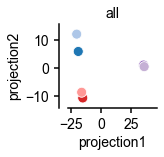

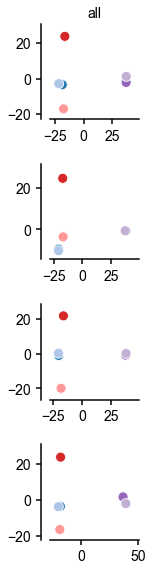

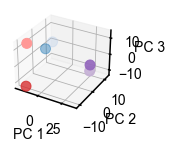

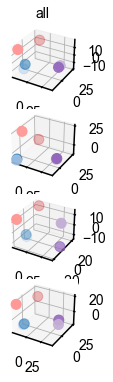

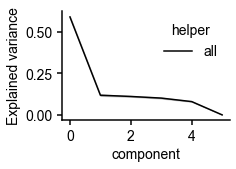

In [13]:
# pooling across all mice (used for imaging data)
pooled_pca, pooled_dists, pooled_avg, pooled_rda, pooled_rdaavg, pooled_var = reduce_pool_mice(
    neuron_info, cue_resps_norm, class_name, class_labels, protocol_info, colors, class_colors,
    late_trace_ind, n_components, n_pca_splits, activity_type=activity_type)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


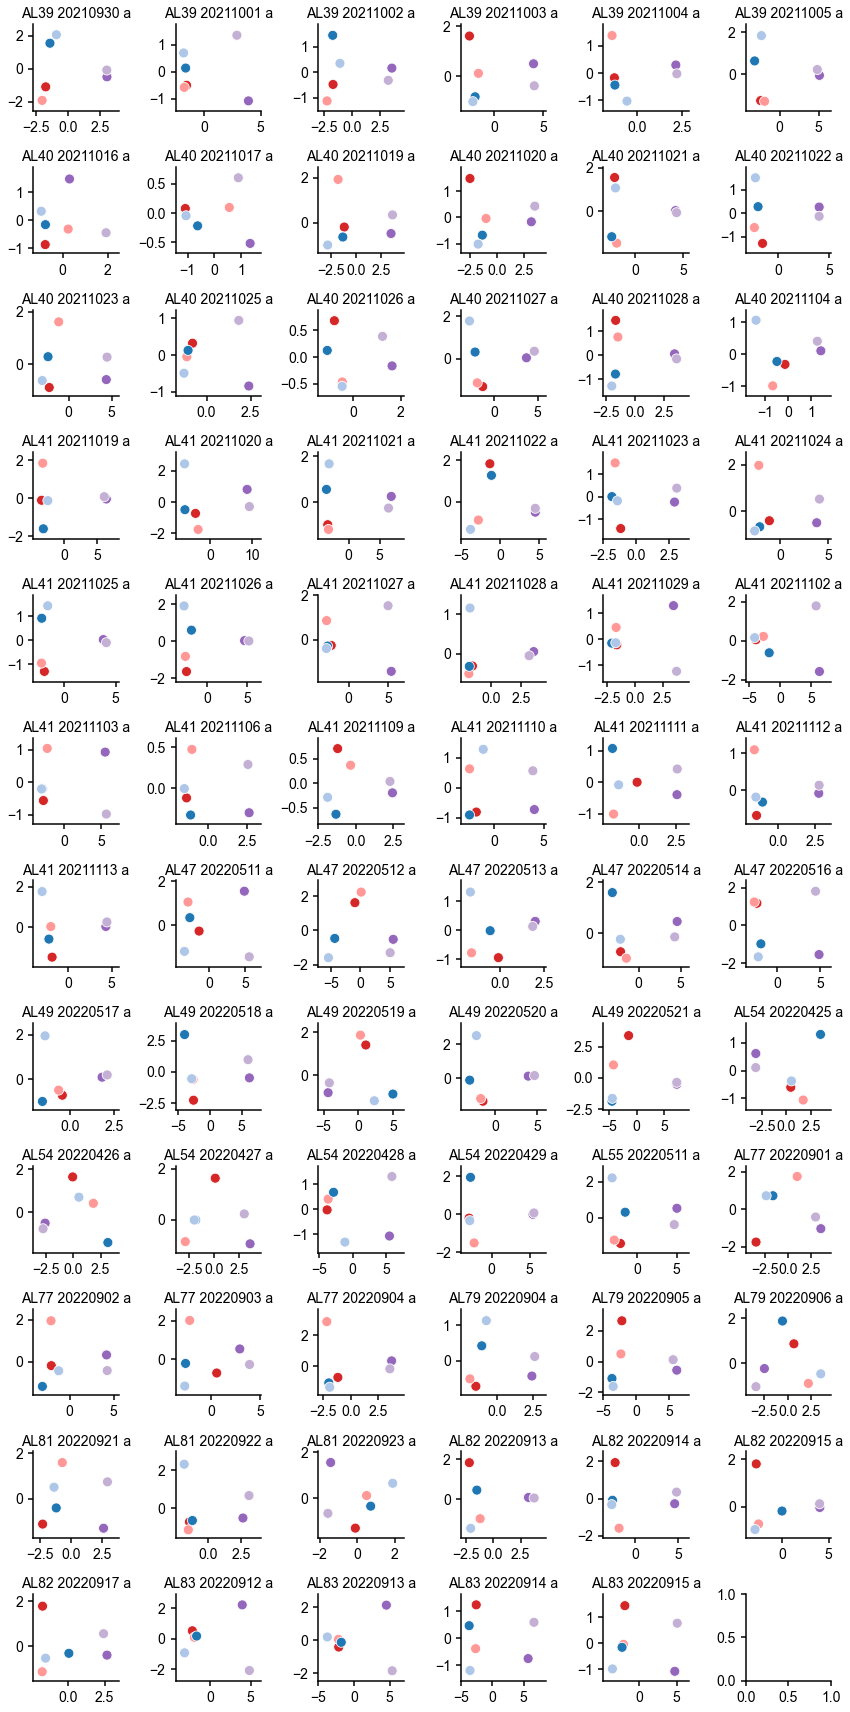

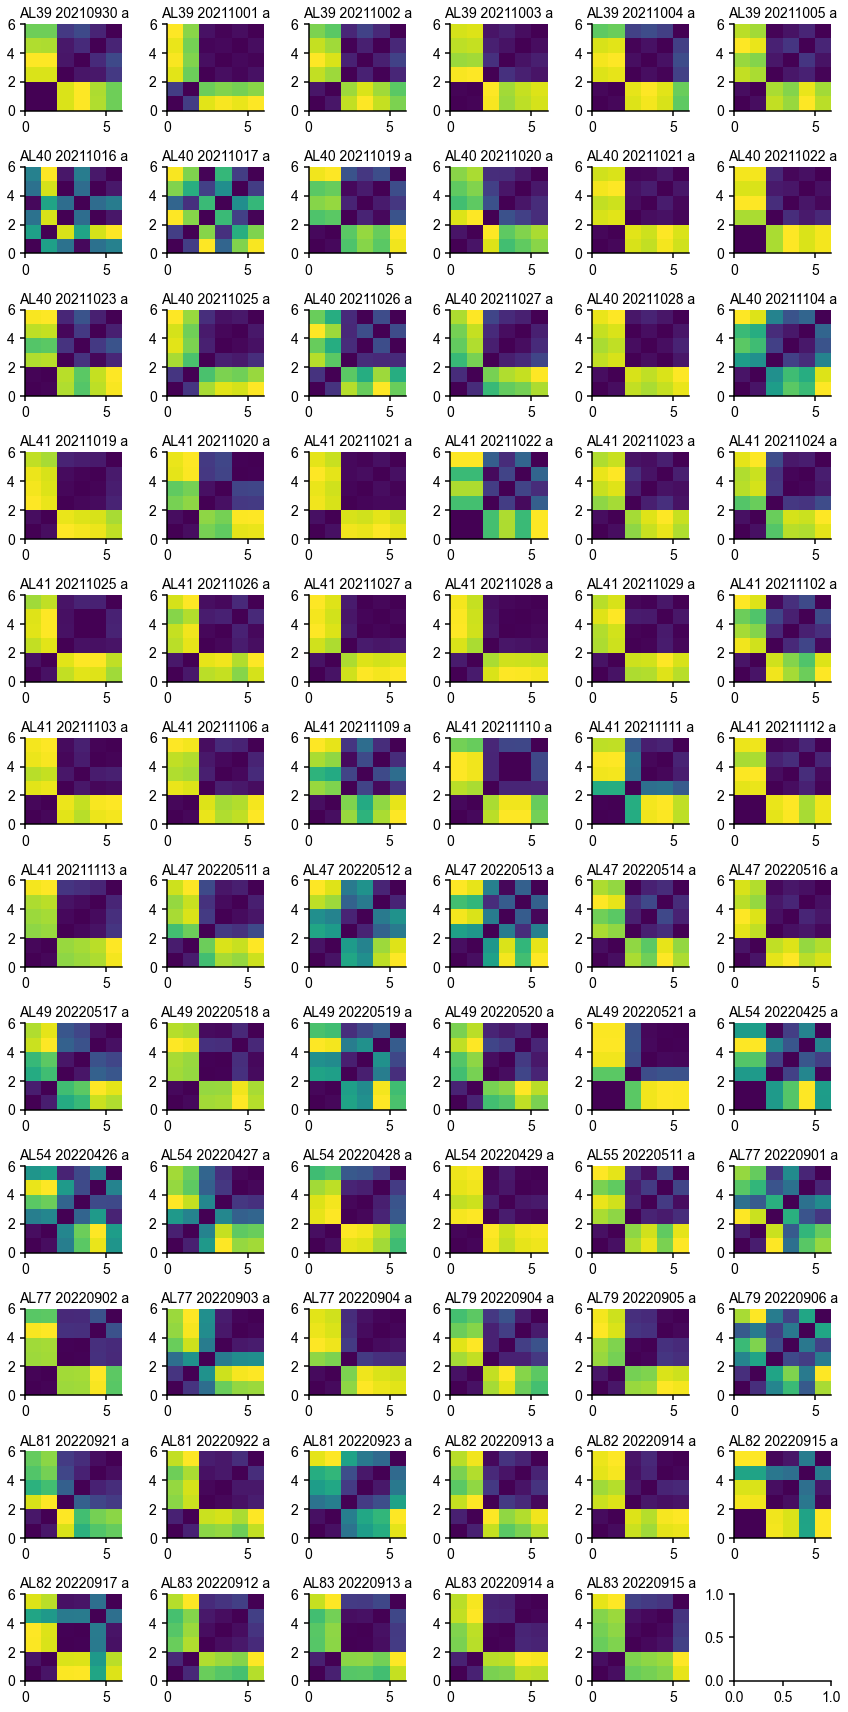

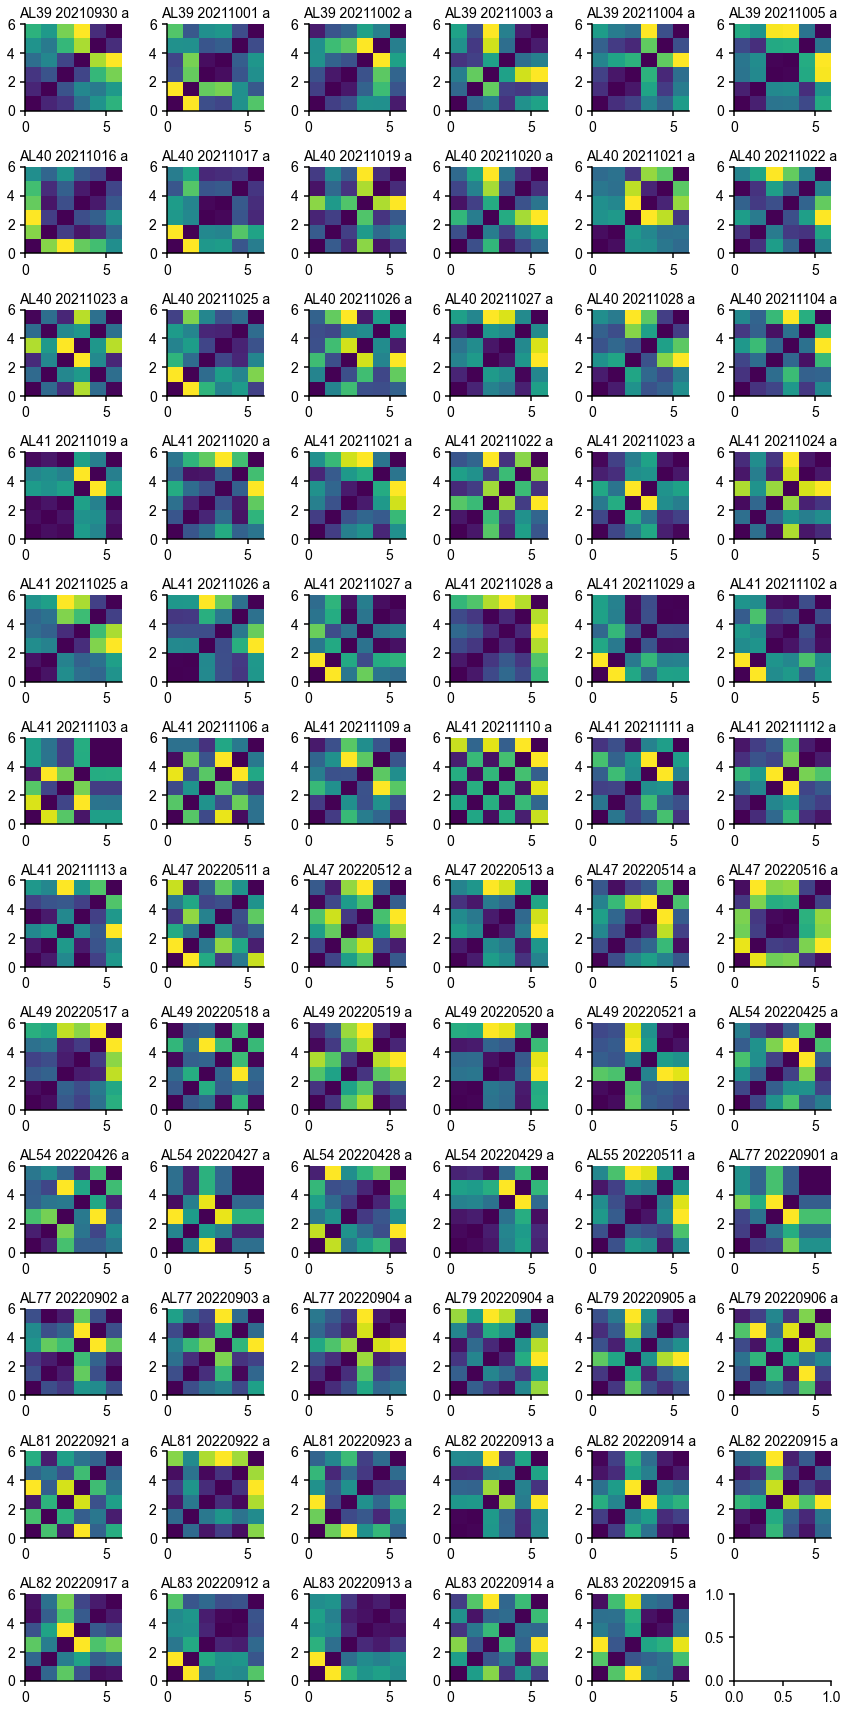

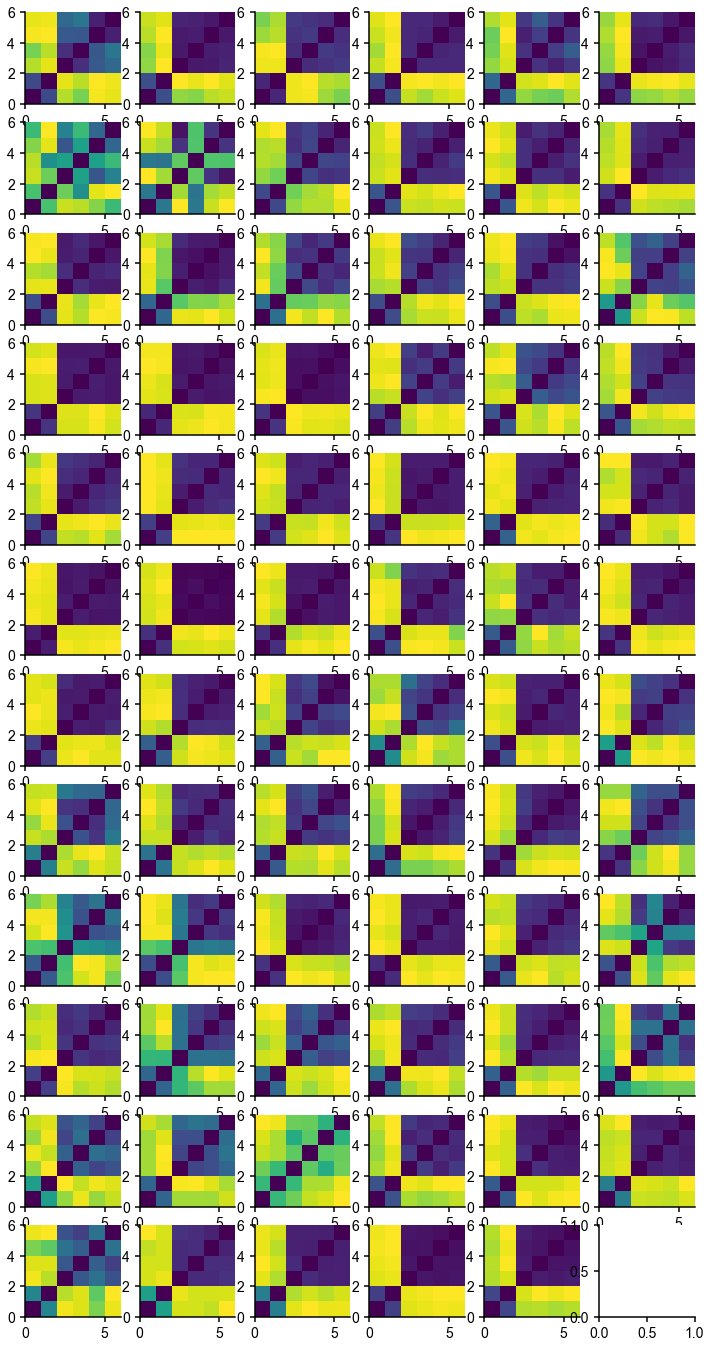

In [14]:
# computed session-wise (Fig. 2)
pairwise_dists, rda, session_avg_components, explained_var, trunc_class_labels = reduce(
    trunc_df, neuron_info, X_means_norm, class_name, protocol_info, colors, late_trace_ind, n_components)

In [15]:
svdf = trunc_df.copy()
svdf[['var1', 'var2']] = 0
svdf[['var1', 'var2']] = np.vstack([v for v in explained_var.values()])
msvdf = svdf.groupby('name').mean()  # average sessionwise pca across mice, then compute summary stats 
msvdf[['var1', 'var2']].agg(['mean', 'sem'])

<ipython-input-15-f3e02796670f>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  msvdf = svdf.groupby('name').mean()  # average sessionwise pca across mice, then compute summary stats


,var1,var2
mean,0.732789,0.109431
sem,0.023276,0.009189


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


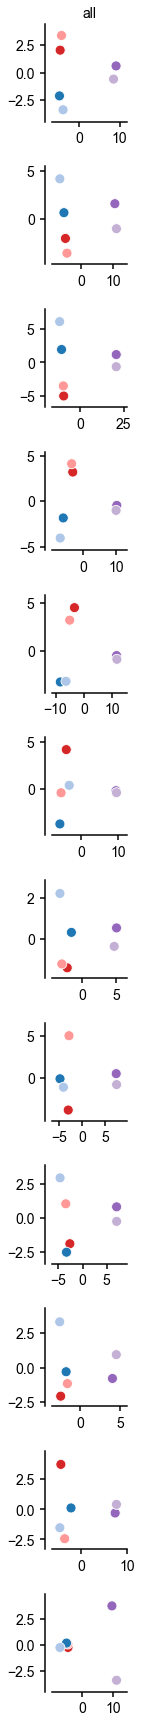

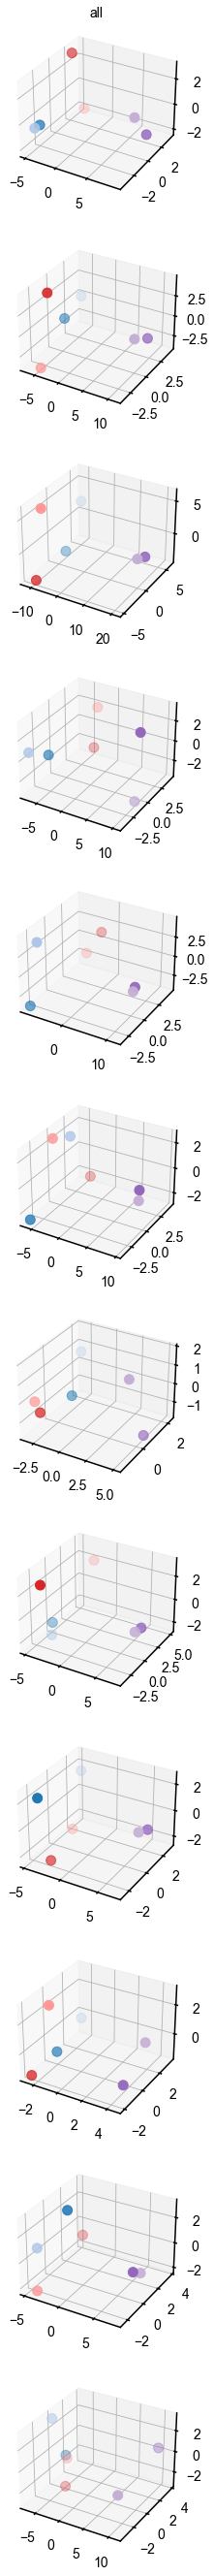

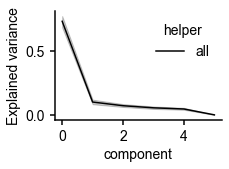

In [16]:
avg_dists, avg_rda = avg_session_dists(trunc_df, pairwise_dists, rda, class_labels, n_trace_types, trunc_class_labels, n_components)
mousewise_pca, mousewise_dists, mousewise_avg, mousewise_rda, mousewise_rdaavg, mousewise_var = reduce_mouse_avg(
    neuron_info, X_means_norm, class_name, class_labels, mice, protocol_info, colors, class_colors, late_trace_ind, n_components)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


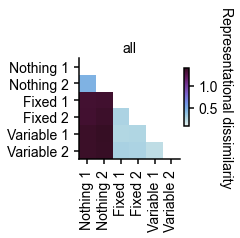

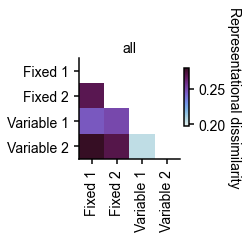

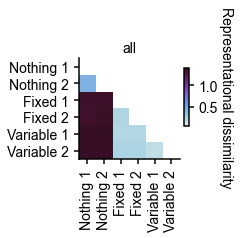

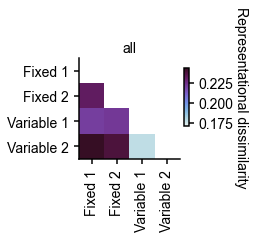

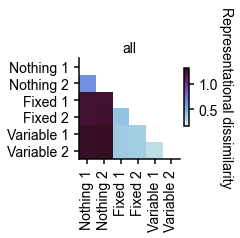

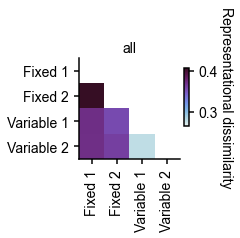

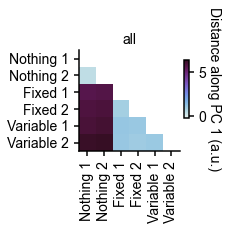

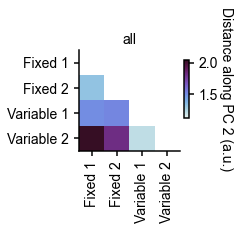

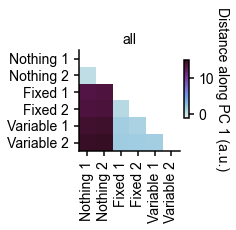

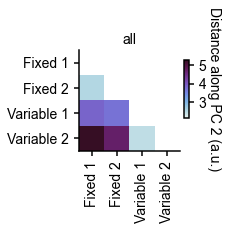

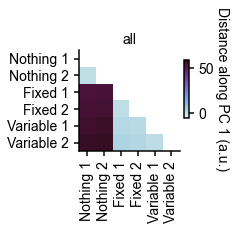

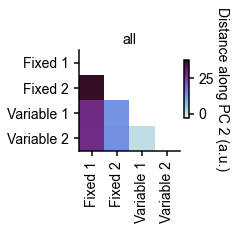

In [17]:
plot_masked_mat(avg_rda, 0, 0, class_labels, 'avg_rda', protocol_info)
plot_masked_mat(avg_rda, 0, 2, class_labels, 'avg_rda', protocol_info)
plot_masked_mat(mousewise_rdaavg, 0, 0, class_labels, 'mouseavg_rda', protocol_info)
plot_masked_mat(mousewise_rdaavg, 0, 2, class_labels, 'mouseavg_rda', protocol_info)
plot_masked_mat(pooled_rdaavg, 0, 0, class_labels, 'pooledavg_rda', protocol_info)
plot_masked_mat(pooled_rdaavg, 0, 2, class_labels, 'pooledavg_rda', protocol_info)
plot_masked_mat(avg_dists, 0, 0, class_labels, 'avg_dists', protocol_info)
plot_masked_mat(avg_dists, 1, 2, class_labels, 'avg_dists', protocol_info)
plot_masked_mat(mousewise_avg, 0, 0, class_labels, 'mousewise_avg', protocol_info)
plot_masked_mat(mousewise_avg, 1, 2, class_labels, 'mousewise_avg', protocol_info)
plot_masked_mat(pooled_avg, 0, 0, class_labels, 'pooled_avg', protocol_info)
plot_masked_mat(pooled_avg, 1, 2, class_labels, 'pooled_avg', protocol_info)

2.0
[-1.  1.  3.  5.  7.]
1.0
[0. 2. 4. 6.]
[array([1., 0., 0., 0.]), array([0., 0., 1., 0.]), array([0. , 0.5, 0. , 0.5])]
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[0 1]
[2 3]
[[0.17391304 0.4137931  0.57142857 0.68292683 0.76595745 0.83018868
  0.88135593 0.92307692 0.95774648 0.98701299]
 [0.01298701 0.04225352 0.07692308 0.11864407 0.16981132 0.23404255
  0.31707317 0.42857143 0.5862069  0.82608696]]
Reflected Expectile
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 6)
50
(1000, 300)
100 10 50 6
(1000, 300)
[[0.00000000e+00 3.18941539e+00 1.33894248e+02 1.34083234e+02
  1.38629408e+02 1.38564338e+02]
 [3.18941539e+00 0.00000000e+00 1.30704833e+02 1.30893819e+02
  1.35439993e+02 1.35374923e+02]
 [1.33894248e+02 1.30704833e+02 0.00000000e+00 1.88985980e-01
  4.73516038e+00 4.67008994e+00]
 [1.34083234e+02 1.30893819e+02 1.88985980e-01 0.00000000e+00
  4.54617440e+00 4.48110396e+00]
 [1.38629408e+02 1.35439993e+02 4.73516038e+00 4.54617440e+00
  0.00000000e+00 6

../behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
../behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Expectile
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 6)
50
(1000, 300)
100 10 50 6
(1000, 300)
[[  0.           2.46304058 129.81704577 130.96656479 138.08324014
  134.8367479 ]
 [  2.46304058   0.         132.28008636 133.42960537 140.54628072
  137.29978848]
 [129.81704577 132.28008636   0.           1.14951901   8.26619437
    5.01970212]
 [130.96656479 133.42960537   1.14951901   0.           7.11667535
    3.87018311]
 [138.08324014 140.54628072   8.26619437   7.11667535   0.
    3.24649224]
 [134.8367479  137.29978848   5.01970212   3.87018311   3.24649224
    0.        ]]
[[ 0.          9.24399071 33.16588219 35.69737307 18.10294823 24.74025386]
 [ 9.24399071  0.         23.92189148 26.45338236 27.34693894 33.98424457]
 [33.16588219 23.92189148  0.          2.53149088 51.26883042 57.90613605]
 [35.69737307 26.45338236  2.53149088  0.         53.8003213  60.43762693]
 [18.10294823 27.34693894 51.26883042 53.8003213   0.          6.63730563]
 [24.74025386 33.984244

../behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
../behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Quantile
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 6)
50
(1000, 300)
100 10 50 6
(1000, 300)
[[  0.           1.10075393 126.89392452 130.79867559 147.42431839
  150.00352526]
 [  1.10075393   0.         125.79317059 129.69792166 146.32356446
  148.90277133]
 [126.89392452 125.79317059   0.           3.90475107  20.53039388
   23.10960074]
 [130.79867559 129.69792166   3.90475107   0.          16.6256428
   19.20484967]
 [147.42431839 146.32356446  20.53039388  16.6256428    0.
    2.57920687]
 [150.00352526 148.90277133  23.10960074  19.20484967   2.57920687
    0.        ]]
[[ 0.          8.56631211 50.91886975 54.56857373 26.86889688 27.30800643]
 [ 8.56631211  0.         42.35255764 46.00226162 35.43520899 35.87431854]
 [50.91886975 42.35255764  0.          3.64970398 77.78776662 78.22687618]
 [54.56857373 46.00226162  3.64970398  0.         81.4374706  81.87658016]
 [26.86889688 35.43520899 77.78776662 81.4374706   0.          0.43910955]
 [27.30800643 35.87431854

../behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
../behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Reflected Quantile
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
(1000, 6)
50
(1000, 300)
100 10 50 6
(1000, 300)
[[  0.           4.59627309 130.9542406  132.00816609 150.79110992
  147.3225497 ]
 [  4.59627309   0.         126.35796751 127.411893   146.19483683
  142.72627661]
 [130.9542406  126.35796751   0.           1.05392549  19.83686932
   16.3683091 ]
 [132.00816609 127.411893     1.05392549   0.          18.78294383
   15.31438362]
 [150.79110992 146.19483683  19.83686932  18.78294383   0.
    3.46856022]
 [147.3225497  142.72627661  16.3683091   15.31438362   3.46856022
    0.        ]]
[[ 0.          2.32775529 49.79661471 43.3536707  32.15144861 27.0778458 ]
 [ 2.32775529  0.         47.46885941 41.02591541 34.47920391 29.40560109]
 [49.79661471 47.46885941  0.          6.44294401 81.94806332 76.87446051]
 [43.3536707  41.02591541  6.44294401  0.         75.50511931 70.4315165 ]
 [32.15144861 34.47920391 81.94806332 75.50511931  0.          5.07360281]
 [27.0778458  

../behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
../behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Distributed AU
[0.05 0.05 0.15 0.15 0.25 0.25 0.35 0.35 0.45 0.45 0.55 0.55 0.65 0.65
 0.75 0.75 0.85 0.85 0.95 0.95]
(2000, 6)
50
(2000, 300)
100 20 50 6
(2000, 300)
[[  0.           1.83084528  89.3980256   97.82186838 361.37562019
  362.24478015]
 [  1.83084528   0.          87.56718032  95.99102311 359.54477491
  360.41393487]
 [ 89.3980256   87.56718032   0.           8.42384279 271.97759459
  272.84675455]
 [ 97.82186838  95.99102311   8.42384279   0.         263.5537518
  264.42291176]
 [361.37562019 359.54477491 271.97759459 263.5537518    0.
    0.86915996]
 [362.24478015 360.41393487 272.84675455 264.42291176   0.86915996
    0.        ]]
[[  0.           9.3003897  124.69857243 125.65966313  19.75546355
   43.35642435]
 [  9.3003897    0.         133.99896214 134.96005284  29.05585326
   52.65681406]
 [124.69857243 133.99896214   0.           0.9610907  104.94310888
   81.34214808]
 [125.65966313 134.96005284   0.9610907    0.         105.90419958
   82.30323878]
 [ 19.75546

../behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
../behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Partial Distributed AU
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 0.05 0.15 0.25 0.35
 0.45 0.55 0.65 0.75 0.85 0.95]
(2000, 6)
50
(2000, 300)
100 20 50 6
(2000, 300)
[[  0.           2.50628591  84.26665792  85.7508343  358.1676589
  358.59171729]
 [  2.50628591   0.          81.76037201  83.2445484  355.66137299
  356.08543138]
 [ 84.26665792  81.76037201   0.           1.48417639 273.90100098
  274.32505937]
 [ 85.7508343   83.2445484    1.48417639   0.         272.4168246
  272.84088299]
 [358.1676589  355.66137299 273.90100098 272.4168246    0.
    0.42405839]
 [358.59171729 356.08543138 274.32505937 272.84088299   0.42405839
    0.        ]]
[[  0.           9.37611716 136.89573454 131.65696705  32.8006737
   54.4607534 ]
 [  9.37611716   0.         127.51961738 122.28084989  23.42455654
   45.08463625]
 [136.89573454 127.51961738   0.           5.23876749 104.09506084
   82.43498114]
 [131.65696705 122.28084989   5.23876749   0.          98.85629335
   77.19621364]
 [ 32

../behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
../behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Actor Uncertainty (AU)
[0.5 0.5]
(200, 6)
50
(200, 300)
100 2 50 6
(200, 300)
[[  0.          15.12436147  17.38076563  17.69180874 135.73370305
  134.92804957]
 [ 15.12436147   0.          32.5051271   32.81617021 150.85806453
  150.05241104]
 [ 17.38076563  32.5051271    0.           0.31104311 118.35293743
  117.54728394]
 [ 17.69180874  32.81617021   0.31104311   0.         118.04189432
  117.23624083]
 [135.73370305 150.85806453 118.35293743 118.04189432   0.
    0.80565349]
 [134.92804957 150.05241104 117.54728394 117.23624083   0.80565349
    0.        ]]
[[ 0.         23.06368764 65.46690771 50.59943098 32.07481896 26.06492338]
 [23.06368764  0.         42.40322006 27.53574333  9.01113132  3.00123573]
 [65.46690771 42.40322006  0.         14.86747673 33.39208874 39.40198433]
 [50.59943098 27.53574333 14.86747673  0.         18.52461201 24.5345076 ]
 [32.07481896  9.01113132 33.39208874 18.52461201  0.          6.00989558]
 [26.06492338  3.00123573 39.40198433 24.5345076   6.009

../behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
../behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Categorical
[0. 2. 4. 6.]
(400, 6)
50
(400, 300)
100 4 50 6
(400, 300)
[[ 0.          0.12607904 15.22515977 15.34246792  7.58291785  7.51258901]
 [ 0.12607904  0.         15.35123881 15.46854696  7.70899689  7.63866805]
 [15.22515977 15.35123881  0.          0.11730815  7.64224192  7.71257077]
 [15.34246792 15.46854696  0.11730815  0.          7.75955007  7.82987891]
 [ 7.58291785  7.70899689  7.64224192  7.75955007  0.          0.07032884]
 [ 7.51258901  7.63866805  7.71257077  7.82987891  0.07032884  0.        ]]
[[ 0.          0.27405257  0.41129178  0.56346095 10.92206093 10.58857767]
 [ 0.27405257  0.          0.68534435  0.28940838 11.19611351 10.86263024]
 [ 0.41129178  0.68534435  0.          0.97475273 10.51076915 10.17728589]
 [ 0.56346095  0.28940838  0.97475273  0.         11.48552188 11.15203862]
 [10.92206093 11.19611351 10.51076915 11.48552188  0.          0.33348327]
 [10.58857767 10.86263024 10.17728589 11.15203862  0.33348327  0.        ]]
(2, 400)
(4, 2) (4,)
[0. 2.

../behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
../behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Laplace
[0. 2. 4. 6.]
(400, 6)
50
(400, 300)
100 4 50 6
(400, 300)
[[ 0.          0.12259185 15.35536234 14.47757063 12.370853   12.74838445]
 [ 0.12259185  0.         15.23277049 14.35497878 12.24826115 12.6257926 ]
 [15.35536234 15.23277049  0.          0.87779172  2.98450935  2.60697789]
 [14.47757063 14.35497878  0.87779172  0.          2.10671763  1.72918618]
 [12.370853   12.24826115  2.98450935  2.10671763  0.          0.37753145]
 [12.74838445 12.6257926   2.60697789  1.72918618  0.37753145  0.        ]]
[[0.         0.86627333 3.41842636 2.42263875 5.91148354 6.42341449]
 [0.86627333 0.         4.28469969 3.28891207 5.04521021 5.55714117]
 [3.41842636 4.28469969 0.         0.99578761 9.3299099  9.84184086]
 [2.42263875 3.28891207 0.99578761 0.         8.33412228 8.84605324]
 [5.91148354 5.04521021 9.3299099  8.33412228 0.         0.51193096]
 [6.42341449 5.55714117 9.84184086 8.84605324 0.51193096 0.        ]]
(2, 400)
(4, 2) (4,)
[0. 2. 4. 6.]
(400, 6)
50
(400, 300)
100 4 50 

../behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
../behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Cumulative
[0. 2. 4. 6.]
(400, 6)
50
(400, 300)
100 4 50 6
(400, 300)
[[0.00000000e+00 4.93470334e-02 1.55155292e+01 1.55265215e+01
  1.29172413e+01 1.26367306e+01]
 [4.93470334e-02 0.00000000e+00 1.54661822e+01 1.54771744e+01
  1.28678943e+01 1.25873836e+01]
 [1.55155292e+01 1.54661822e+01 0.00000000e+00 1.09922476e-02
  2.59828791e+00 2.87879861e+00]
 [1.55265215e+01 1.54771744e+01 1.09922476e-02 0.00000000e+00
  2.60928016e+00 2.88979086e+00]
 [1.29172413e+01 1.28678943e+01 2.59828791e+00 2.60928016e+00
  0.00000000e+00 2.80510700e-01]
 [1.26367306e+01 1.25873836e+01 2.87879861e+00 2.88979086e+00
  2.80510700e-01 0.00000000e+00]]
[[ 0.          0.32230004  2.22059503  3.58125965  6.56189755  4.84974216]
 [ 0.32230004  0.          2.54289507  3.90355969  6.23959751  4.52744212]
 [ 2.22059503  2.54289507  0.          1.36066462  8.78249258  7.07033718]
 [ 3.58125965  3.90355969  1.36066462  0.         10.1431572   8.43100181]
 [ 6.56189755  6.23959751  8.78249258 10.1431572   0.      

../behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
../behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


Moments
[0.5 0.5]
(200, 6)
50
(200, 300)
100 2 50 6
(200, 300)
[[0.00000000e+00 2.13068322e-02 2.71999395e+01 2.72759819e+01
  5.64342947e+01 6.20759701e+01]
 [2.13068322e-02 0.00000000e+00 2.72212463e+01 2.72972888e+01
  5.64556015e+01 6.20972769e+01]
 [2.71999395e+01 2.72212463e+01 0.00000000e+00 7.60424280e-02
  2.92343552e+01 3.48760305e+01]
 [2.72759819e+01 2.72972888e+01 7.60424280e-02 0.00000000e+00
  2.91583128e+01 3.47999881e+01]
 [5.64342947e+01 5.64556015e+01 2.92343552e+01 2.91583128e+01
  0.00000000e+00 5.64167536e+00]
 [6.20759701e+01 6.20972769e+01 3.48760305e+01 3.47999881e+01
  5.64167536e+00 0.00000000e+00]]
[[ 0.          0.99332229 36.11470847 31.2586361   1.80418134  5.58641005]
 [ 0.99332229  0.         35.12138618 30.26531381  2.79750363  4.59308776]
 [36.11470847 35.12138618  0.          4.85607237 37.91888981 30.52829842]
 [31.2586361  30.26531381  4.85607237  0.         33.06281744 25.67222605]
 [ 1.80418134  2.79750363 37.91888981 33.06281744  0.          7.3

../behavior_analysis/drl_model_predictions.py:541: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=45, ha='right', rotation_mode='anchor')
../behavior_analysis/drl_model_predictions.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


(1, 11, 2, 4) (1, 11, 2, 4) (1, 11, 2, 4)
2 4 1


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


pc1
                     Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         r       
No. Observations:           781             Method:                     REML    
No. Groups:                 12              Scale:                      0.0068  
Min. group size:            11              Log-Likelihood:             798.4680
Max. group size:            209             Converged:                  Yes     
Mean group size:            65.1                                                
--------------------------------------------------------------------------------
                  Coef.     Std.Err.     z        P>|z|      [0.025     0.975]  
--------------------------------------------------------------------------------
Intercept        9.427e-01 1.158e-02  8.140e+01  0.000e+00  9.200e-01  9.654e-01
C(i_code)[T.1]   1.208e-03 1.382e-02  8.742e-02  9.303e-01 -2.588e-02  2.830e-02
C(i_code)[T.2]   2.742e-03 1.382e-02  1.984e-0

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:3910: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rsa_df_mouseavg = rsa_df.groupby(['name', 'code', 'i_code', 'metric'], as_index=False).mean()
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


                     Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         r      
No. Observations:           781             Method:                     REML   
No. Groups:                 12              Scale:                      0.0432 
Min. group size:            11              Log-Likelihood:             78.3913
Max. group size:            209             Converged:                  Yes    
Mean group size:            65.1                                               
-------------------------------------------------------------------------------
                  Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------------
Intercept        4.377e-01 4.222e-02  1.037e+01 3.469e-25  3.550e-01  5.205e-01
C(i_code)[T.1]   2.297e-02 3.487e-02  6.588e-01 5.100e-01 -4.537e-02  9.131e-02
C(i_code)[T.2]   6.479e-03 3.487e-02  1.858e-01 8.526e-01 -6.

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includ

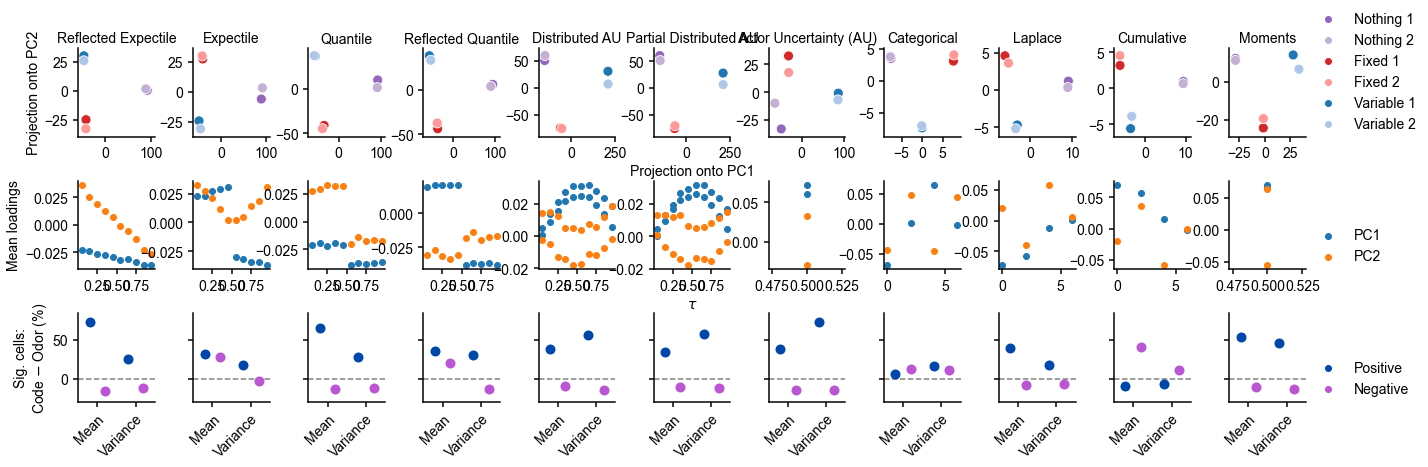

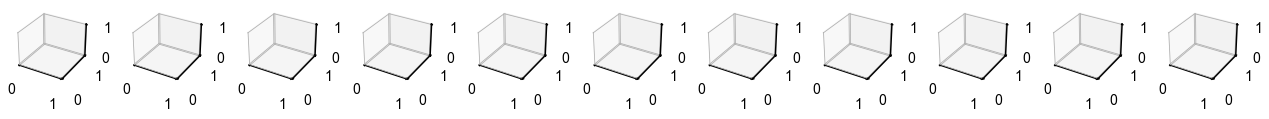

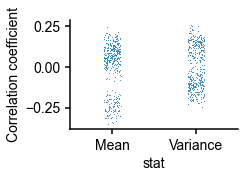

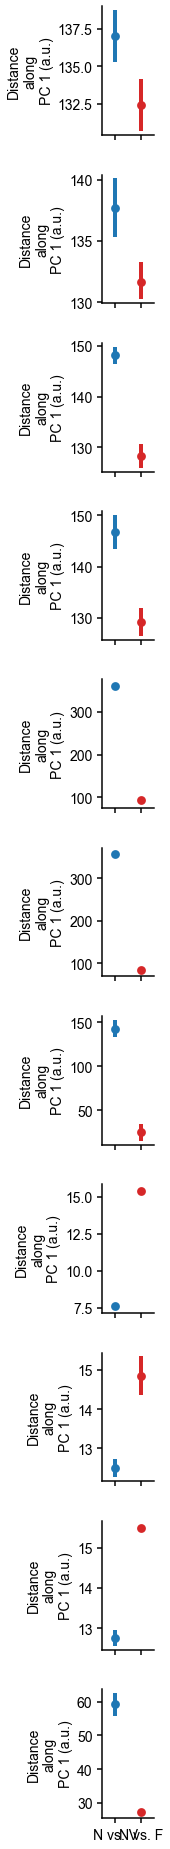

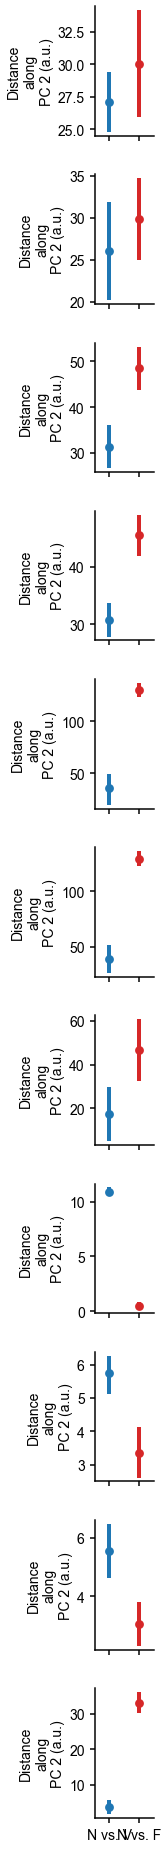

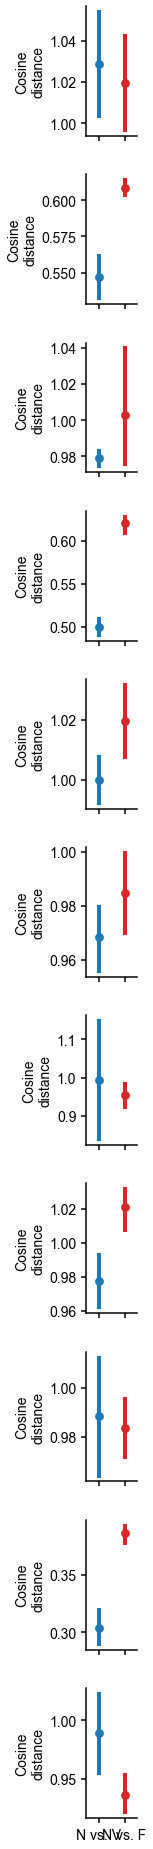

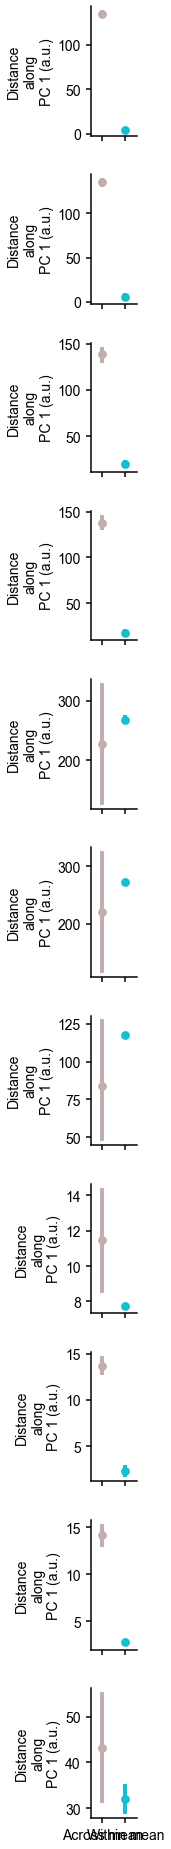

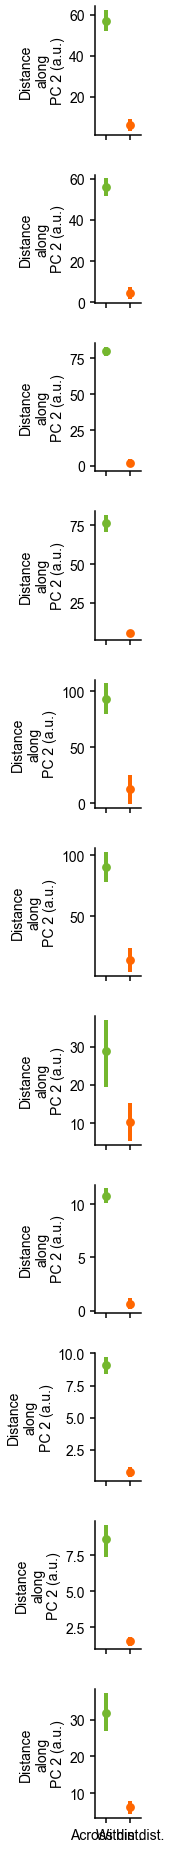

<Figure size 288x216 with 0 Axes>

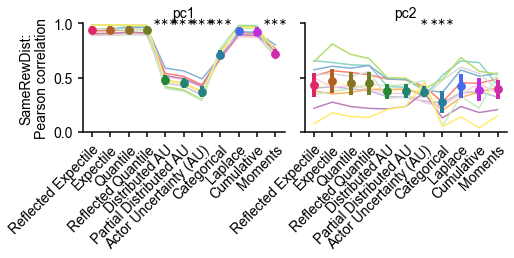

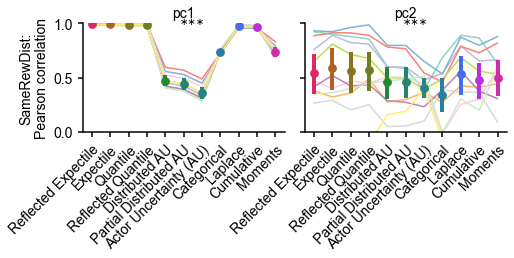

In [18]:
if class_name != 'lesion':
    subsets = ['all', 'pess', 'opt'] if table == 'imaging' else ['all']
    df_list, code_order, info, reduced_activities, all_dists, all_rda = generate_model_predictions(
        protocol_info, colors, cat=True, noise_scale=5, subsets=subsets)
    if table == 'ephys':
        compute_model_rsa(ret_df, code_order, all_dists, all_rda, pairwise_dists, rda, mousewise_dists, mousewise_rda, mouse_colors, protocol)

# CCGP, pairwise, congruency, and odor decoding analyses
## Generated plots include Fig. 2c, 3i-k, 4h, and ED Fig. 2i-l, 3, 4a-c, 8h-j.
#### Training and testing on the Late Trace period corresponds to `per_key = '3_3'`
#### Run this only on `fig2`, `fig3`, `fig4`, or `EDfig8`, otherwise it will break because it doesn't have the 2x2 structure

In [20]:
# parameters for decoding
pers_base = [1, 2, 3]
train_pers = np.repeat(pers_base, len(pers_base))
test_pers = np.tile(pers_base, len(pers_base))

per_keys = ['_'.join([str(train_per), str(test_per)]) for train_per, test_per in zip(train_pers, test_pers)]
use_pop = 'max'
reg_C = 5e-3
n_splits = 6

dec_path = os.path.join('../../data', '_'.join([protocol, 'dec_dict', table, spec, activity_type, class_name, 
                                                str(n_splits), str(reg_C), hashed + '.p']))

In [21]:
if os.path.exists(dec_path):
    print(f'Found dec_path at {dec_path}. Loading requires at least {os.path.getsize(dec_path) / (1024**3):.2f} additional GB RAM')
    with open(dec_path, 'rb') as f:
        dec_dict = pickle.load(f)
else:
    print(f'Could not find dec_path at {dec_path}. If you did not intend to run your own decoding, please copy the data from the data repo.')
    dec_dict = dec_dict_setup(cue_resps, all_spk_cnts[:n_trace_types] / psth_bin_width, psth_bin_centers,
                          protocol_info, kwargs, train_pers=train_pers, test_pers=test_pers)

    dec_dict = pseudo_decode_by_class(class_name, class_labels, dec_dict, neuron_info, rois,
                                  n_splits=n_splits, by_mouse=bm, match_across_class=mac, 
                                  match_across_reg=mar, reg_C=reg_C, do_zscore=True)  # zscore only within test set, rather than whole session

    print('starting simultaneous decoding')
    for shuff in [False, True]:  # right now, shuff only runs for period '3_3'
        dec_dict = simul_decode_by_class(class_name, class_labels, dec_dict, neuron_info, rois, reg_C=reg_C,
                                         do_zscore=True, shuffle=shuff)  # zscore only within test set, rather than whole session 
    with open(dec_path, 'wb') as f:
        pickle.dump(dec_dict, f)

Found dec_path at ../../data/SameRewDist_dec_dict_ephys_striatum_spks_helper_6_0.005_b7437f9cb619f562f224c5af16a0ce35.p. Loading requires at least 16.67 additional GB RAM


In [22]:
dec_dict = make_dfs(class_name, class_labels, dec_dict, rois, by_mouse=bm, pseudo=True)
dec_dict = make_dfs(class_name, class_labels, dec_dict, rois, by_mouse=True, pseudo=False)

ccgp
pair
cong
mean
odor
ccgp
pair
cong
mean
odor
ccgp
pair
cong
mean
odor


In [23]:
for per_key in per_keys:
    dec_dict = run_stats(class_name, class_labels, rois, dec_dict, per_key, by_mouse=bm)

ccgp
disagg
pool
pair
disagg
AL39
Accuracy ~ C(Subregion) * C(grouping)
No data for Subregion = OT between helper. Skipping
Accuracy ~ C(grouping)
No data for Subregion = mAcbSh between helper. Skipping
Accuracy ~ C(grouping)
No data for Subregion = core between helper. Skipping
Accuracy ~ C(grouping)
No data for Subregion = VLS between helper. Skipping
No data for Subregion = DMS between helper. Skipping
No data for Subregion = DLS between helper. Skipping
Accuracy ~ C(grouping)
AL40
Accuracy ~ C(Subregion) * C(grouping)
No data for Subregion = OT between helper. Skipping
Accuracy ~ C(grouping)
No data for Subregion = mAcbSh between helper. Skipping
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
No data for Subregion = VLS between helper. Skipping
Accuracy ~ C(grouping)
No data for Subregion = DLS between helper. Skipping
Accuracy ~ C(grouping)
AL41
Accuracy ~ C(Subregion) * C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
Accuracy ~ C(grouping)
Accuracy

In [ ]:
if table == 'imaging':
    plot_decode_by_class(class_name, class_labels, dec_dict, per_keys, rois, pseudo=psd,
                         n_splits=n_splits, class_colors=class_colors, activity_type=activity_type)
else:
    plot_mouse_decode_by_class(class_name, class_labels, dec_dict, per_keys=per_keys, rois=['All Subregions'],
                           pseudo=psd, n_splits=n_splits, mouse_colors=mouse_colors, class_colors=class_colors,
                           test='lme', activity_type=activity_type)

    # Beware, plotting this part below takes a long time (~30 minutes), and is not necessary for later 
    # analyses. when plotting across subregions, use pseudo-populations to match neuron counts
    if class_name == 'helper':
        plot_mouse_decode_by_class(class_name, class_labels, dec_dict, per_keys, rois, pseudo=True,
                                   n_splits=n_splits, mouse_colors=mouse_colors, class_colors=class_colors, reg_C=reg_C, test='lme')

In [ ]:
# odor decoding
if table == 'ephys':
    plot_avg_confusion_mat_by_class(class_name, class_labels, dec_dict, ['1_1'], n_trace_types, protocol_info, 
                                    pseudo=psd, activity_type=activity_type, mouse_colors=mouse_colors, class_colors=class_colors)

## Close the loop on PCA analysis now that we have `dec_dict`

pca mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1


/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     dist     
No. Observations:       71          Method:                 REML     
No. Groups:             12          Scale:                  3.6002   
Min. group size:        1           Log-Likelihood:         -148.7702
Max. group size:        19          Converged:              Yes      
Mean group size:        5.9                                          
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 4.329e+00 3.076e-01 1.407e+01 5.599e-45 3.726e+00 4.932e+00
mouse Var 3.973e-01 2.159e-01                                        

[0.5] [5.599e-45]


meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pca pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      dist    
No. Observations:      71           Method:                  REML    
No. Groups:            12           Scale:                   0.5920  
Min. group size:       1            Log-Likelihood:          -88.3855
Max. group size:       19           Converged:               Yes     
Mean group size:       5.9                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 4.138e-01 1.652e-01 2.504e+00 1.228e-02 8.991e-02 7.376e-01
mouse Var 1.941e-0

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pca odor ['all']
['Nothing vs. Variable', 'Nothing vs. Fixed']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Variable', 'Nothing vs. Fixed']
['Nothing vs. Variable', 'Nothing vs. Fixed']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      dist    
No. Observations:      71           Method:                  REML    
No. Groups:            12           Scale:                   0.7200  
Min. group size:       1            Log-Likelihood:          -93.6822
Max. group size:       19           Converged:               Yes     
Mean group size:       5.9                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 4.333e-01 1.561e-01 2.776e+00 5.497e-03 1.274e-01 7.392e-01
mouse Var 1.386e-01 1

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_pca mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      dist    
No. Observations:      12           Method:                  REML    
No. Groups:            12           Scale:                   2.4637  
Min. group size:       1            Log-Likelihood:          -35.5062
Max. group size:       1            Converged:               Yes     
Mean group size:       1.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.126e+01 1.574e+00 7.157e+00 8.221e-13 8.180e+00 1.435e+01
mouse Var 2.726e+01                                         

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_pca pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      dist    
No. Observations:      12           Method:                  REML    
No. Groups:            12           Scale:                   0.7673  
Min. group size:       1            Log-Likelihood:          -27.9660
Max. group size:       1            Converged:               Yes     
Mean group size:       1.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.890e+00 7.930e-01 2.383e+00 1.716e-02 3.357e-01 3.444e+00
mouse Var 6.

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_pca odor ['all']
['Nothing vs. Variable', 'Nothing vs. Fixed']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Variable', 'Nothing vs. Fixed']
['Nothing vs. Variable', 'Nothing vs. Fixed']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      dist    
No. Observations:      12           Method:                  REML    
No. Groups:            12           Scale:                   0.3129  
Min. group size:       1            Log-Likelihood:          -19.4829
Max. group size:       1            Converged:               Yes     
Mean group size:       1.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.025e+00 3.667e-01 2.795e+00 5.187e-03 3.063e-01 1.744e+00
mouse Var 1.301

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_pca mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
stat = 79.6407, pval = 0.0000
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      dist   
No. Observations:       4            Method:                  REML   
No. Groups:             4            Scale:                   0.0992 
Min. group size:        1            Log-Likelihood:          -5.5156
Max. group size:        1            Converged:               Yes    
Mean group size:        1.0                                          
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 4.808e+01 6.037e-01 7.964e+01 0.000e+00 4.690e+01 4.927e+01
mouse Var 1.359e+00 2.392e+08

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_pca pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
stat = 0.7826, pval = 0.4910
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      dist   
No. Observations:        4            Method:                  REML   
No. Groups:              4            Scale:                   0.9601 
Min. group size:         1            Log-Likelihood:          -8.3427
Max. group size:         1            Converged:               Yes    
Mean group size:         1.0                                          
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.212e+00 1.549e+00 7.826e-01 4.3

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_pca odor ['all']
['Nothing vs. Variable', 'Nothing vs. Fixed']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Variable', 'Nothing vs. Fixed']
stat = 4.0245, pval = 0.0276
['Nothing vs. Variable', 'Nothing vs. Fixed']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      dist   
No. Observations:       4            Method:                  REML   
No. Groups:             4            Scale:                   0.0951 
Min. group size:        1            Log-Likelihood:          -5.8704
Max. group size:        1            Converged:               Yes    
Mean group size:        1.0                                          
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.735e+00 6.795e-01 4.025e+00 5.710e-05 1.403

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

rda mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      dist  
No. Observations:        71           Method:                  REML  
No. Groups:              12           Scale:                   0.0331
Min. group size:         1            Log-Likelihood:          9.7361
Max. group size:         19           Converged:               Yes   
Mean group size:         5.9                                         
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.015e+00 5.101e-02 1.990e+01 4.363e-88 9.149e-01 1.115e+00
mouse Var 2.317e-02 8.365e-02                                     

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

rda pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      dist    
No. Observations:      71           Method:                  REML    
No. Groups:            12           Scale:                   0.0027  
Min. group size:       1            Log-Likelihood:          101.6373
Max. group size:       19           Converged:               Yes     
Mean group size:       5.9                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.271e-02 1.026e-02 2.214e+00 2.683e-02 2.605e-03 4.281e-02
mouse Var 6.796e-0

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

rda odor ['all']
['Nothing vs. Variable', 'Nothing vs. Fixed']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Variable', 'Nothing vs. Fixed']
['Nothing vs. Variable', 'Nothing vs. Fixed']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      dist   
No. Observations:       71           Method:                  REML   
No. Groups:             12           Scale:                   0.0069 
Min. group size:        1            Log-Likelihood:          71.3867
Max. group size:        19           Converged:               Yes    
Mean group size:        5.9                                          
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 3.938e-02 1.155e-02 3.409e+00 6.511e-04 1.674e-02 6.201e-02
mouse Var 2.976e-04 6

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_rda mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       dist  
No. Observations:       12            Method:                   REML  
No. Groups:             12            Scale:                    0.0056
Min. group size:        1             Log-Likelihood:           2.8191
Max. group size:        1             Converged:                Yes   
Mean group size:        1.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|      [0.025    0.975] 
----------------------------------------------------------------------
Intercept 1.046e+00 4.829e-02 2.166e+01 5.407e-104 9.510e-01 1.140e+00
mouse Var 2.238e-02 8.198e+06                     

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_rda pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      dist   
No. Observations:       12           Method:                  REML   
No. Groups:             12           Scale:                   0.0001 
Min. group size:        1            Log-Likelihood:          19.5788
Max. group size:        1            Converged:               Yes    
Mean group size:        1.0                                          
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.605e-02 1.052e-02 2.475e+00 1.331e-02 5.423e-03 4.667e-02
mouse Var 1.

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

mouse_rda odor ['all']
['Nothing vs. Variable', 'Nothing vs. Fixed']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Variable', 'Nothing vs. Fixed']


/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


['Nothing vs. Variable', 'Nothing vs. Fixed']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      dist   
No. Observations:       12           Method:                  REML   
No. Groups:             12           Scale:                   0.0003 
Min. group size:        1            Log-Likelihood:          19.2024
Max. group size:        1            Converged:               Yes    
Mean group size:        1.0                                          
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.609e-02 1.089e-02 2.396e+00 1.656e-02 4.750e-03 4.743e-02
mouse Var 1.138e-03                                                  

[0.5] [0.01656]


meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_rda mean ['all']
['Across mean', 'Within mean']
Subregion ['All Subregions'] helper ['all'] grouping ['Across mean', 'Within mean']
stat = 137.9767, pval = 0.0000
['Across mean', 'Within mean']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      dist  
No. Observations:        4            Method:                  REML  
No. Groups:              4            Scale:                   0.0000
Min. group size:         1            Log-Likelihood:          8.2457
Max. group size:         1            Converged:               Yes   
Mean group size:         1.0                                         
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 8.482e-01 6.147e-03 1.380e+02 0.000e+00 8.362e-01 8.603e-01
mouse Var 1.013e-04         

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_rda pair ['all']
['Across distribution', 'Within distribution']
Subregion ['All Subregions'] helper ['all'] grouping ['Across distribution', 'Within distribution']
stat = 5.9576, pval = 0.0095
['Across distribution', 'Within distribution']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      dist  
No. Observations:        4            Method:                  REML  
No. Groups:              4            Scale:                   0.0000
Min. group size:         1            Log-Likelihood:          9.8037
Max. group size:         1            Converged:               Yes   
Mean group size:         1.0                                         
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.179e-02 3.657e-03 5.958e+00 2.560e-09 1.

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysis_by_class.py:2654: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = sub_df.groupby([unit, 'Subregion', class_name, grping, 'dec_key']).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._

pooled_rda odor ['all']
['Nothing vs. Variable', 'Nothing vs. Fixed']
Subregion ['All Subregions'] helper ['all'] grouping ['Nothing vs. Variable', 'Nothing vs. Fixed']
stat = 8.0948, pval = 0.0039
['Nothing vs. Variable', 'Nothing vs. Fixed']
0 1 1 1
dist ~ 1
                Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      dist  
No. Observations:        4            Method:                  REML  
No. Groups:              4            Scale:                   0.0000
Min. group size:         1            Log-Likelihood:          8.7982
Max. group size:         1            Converged:               Yes   
Mean group size:         1.0                                         
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 4.139e-02 5.113e-03 8.095e+00 5.735e-16 3.137

meta NOT subset; don't know how to subset; dropped


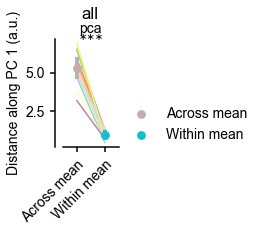

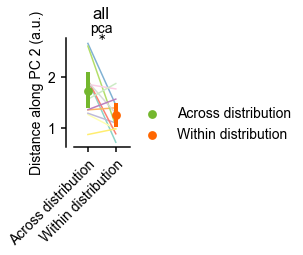

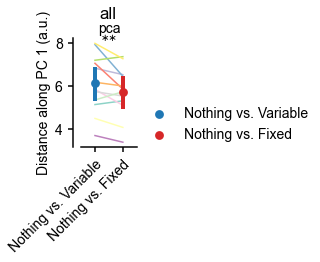

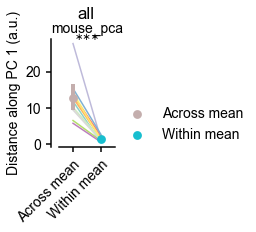

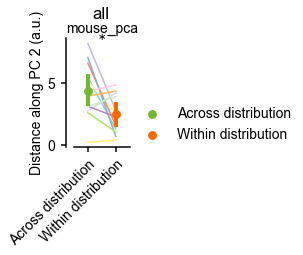

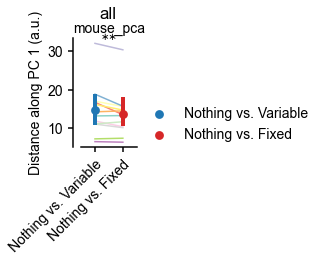

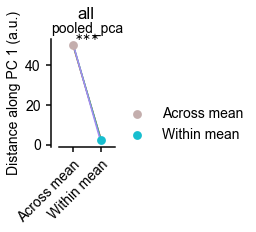

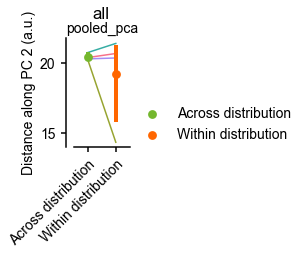

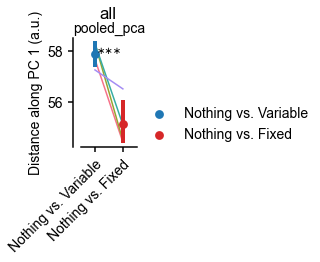

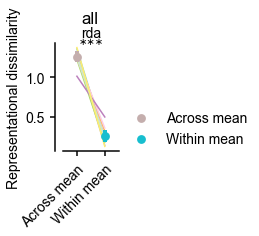

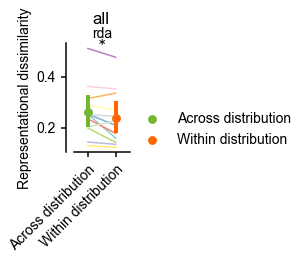

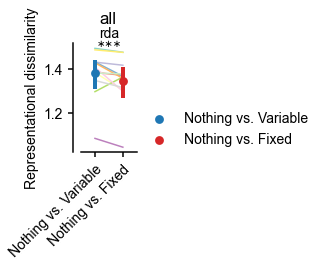

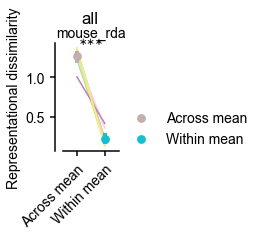

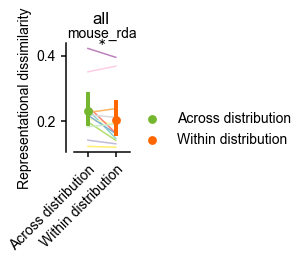

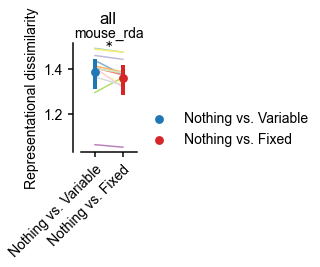

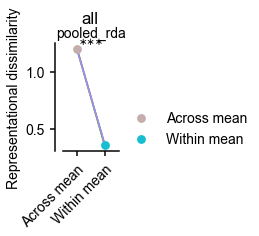

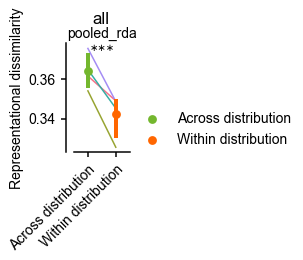

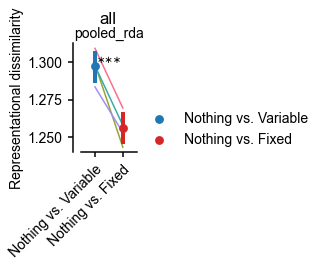

In [24]:
if 'Same' in protocol:  # can't run this for Bernoulli or DiverseDists
    if table == 'imaging':
        sess_class_labels = np.empty(len(ret_df), dtype=object)
        for index, row in ret_df.iterrows():
            cell_inds = np.logical_and(neuron_info['fig_paths'] == row['figure_path'], ~neuron_info[class_name].isnull())
            sess_class_label = np.unique(neuron_info.loc[cell_inds, class_name])
            assert len(sess_class_label) == 1
            sess_class_labels[index] = sess_class_label[0]
            
        reduce_stats(pairwise_dists, mousewise_dists, pooled_dists, rda, mousewise_rda, pooled_rda, ret_df, dec_dict, 
                 protocol_info, class_name, class_labels, sess_class_labels, mice, mouse_colors,
                 n_components, trunc_df, trunc_class_labels, n_splits=n_pca_splits, activity_type=activity_type)
    else:
        reduce_stats(pairwise_dists, mousewise_dists, pooled_dists, rda, mousewise_rda, pooled_rda, ret_df, dec_dict, 
                 protocol_info, class_name, class_labels, trunc_class_labels, mice, mouse_colors,
                 n_components, n_splits=n_pca_splits, activity_type=activity_type)

### Decoder angles, ED Fig. 3f-g.

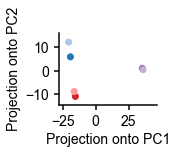

In [26]:
if protocol == 'SameRewDist':
    # do a straightforward, no frills PCA on the late cue resps
    n_components = 3
    pca = PCA(n_components=n_components)
    components = {}
    fig, axs = plt.subplots(1, len(class_labels), figsize=(2.5*len(class_labels), 2), squeeze=False)
    for i_cls, class_label in enumerate(class_labels):
        projection = pca.fit_transform(X_means_norm[:n_trace_types, neuron_info[class_name] == class_label, late_trace_ind])
        components[class_label] = pca.components_
        
        ax = axs[0, i_cls]
        ax.scatter(projection[:, 0], projection[:, 1], color=colors['colors'][:n_trace_types])
        ax.set_xlabel('Projection onto PC1')
        ax.set_ylabel('Projection onto PC2')
        ax.set_ylim(np.array(ax.get_ylim())*1.2)
        ax.set_xlim(np.array(ax.get_xlim())*1.2)
    #     ax.set_title(class_label)
    
    fig.tight_layout()
    hide_spines()

In [ ]:
if protocol == 'SameRewDist':

    print('Computing angles. This may take a long time.')
    angle_df, control_df = compute_angles(dec_dict, neuron_info, cue_resps, protocol_info, components,
                                      session_avg_components, ret_df, class_name, class_labels, rois, 
                                      n_splits=n_splits, train_per=3, test_per=3, do_zscore=True)
    print('Plotting...')
    plot_decoder_angles(dec_dict['per'], control_df, angle_df, class_name, class_labels, ['All Subregions'], n_components,
                    mouse_colors=mouse_colors, dec_types=['simul'])

Computing angles. This may take a long time.


# Parallelism score
## Generated plots include Fig. 2b, 3g, ED Figure 4d
#### Run this only on `fig2`, `fig3`, `fig4`, or `EDfig8`, otherwise it will break because it doesn't have the 2x2 structure

In [ ]:
if table == 'ephys':
    
    simul_ps_resps = compute_parallelism_split_interaction_by_class(
        class_name, class_labels, neuron_info, cue_resps_norm, periods, rois=['All Subregions'], use_size=100)
    
    simul_ps = plot_parallelism_interaction_by_class(
        class_name, simul_ps_resps, periods, rois=['All Subregions'], mouse_colors=mouse_colors, 
        class_colors=class_colors, activity_type=activity_type)
    
    if class_name == 'helper':
        # only for comparison across subregions in ED Fig. 4d
        pseudo_ps_resps = compute_parallelism_split_interaction_by_class(
            class_name, class_labels, neuron_info, cue_resps_norm, periods, rois, use_size=40, pseudo=True)
        
        pseudo_ps = plot_parallelism_interaction_by_class(
            class_name, pseudo_ps_resps, periods, rois=rois, mouse_colors=mouse_colors,
            class_colors=class_colors, pseudo=True, activity_type=activity_type)

# Single-neuron correlations
## Generated plots include Fig. 4e-f, ED Fig. 2c-d, f-h, m-r, 7o, 8f

In [ ]:
trace_dict = {'cs_in': 0,
    'cs_out': 1,
    'trace_end': 3,
    'xlim': (-1, 5),
    'ylabel': '',
    'xlabel': 'Time from CS (s)'
}

sign_labels = ['Positive', 'Negative']
sign_colors = {'Negative': '#BA55D3', 'Positive': '#0047AB'}

In [ ]:
# can also examine other use_keys, like ['resid_var', 'resid_cvar', 'var', 'cvar',
# 'nolick_mean', 'resid_mean', 'rew'], but some of these only exist for SameRewDist right now
use_keys = ['mean', 'rpe']   # ]  # corr_keys
use_inds = None  # use all neurons
# # restrict to MSNs
# use_inds = neuron_info['cell_types'] == 'MSN'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for use_corrs, n_bins, timebase in zip([corrs, corrs_seconds], [n_psth_bins, n_periods], [psth_bin_centers, np.arange(-.5, 4)]):                
        use_corrs = compute_sig_frac_by_class('str_regions', rois, use_corrs, neuron_info, use_keys, n_bins, inds=use_inds)

In [ ]:
use_corrs = corrs  # corrs_seconds
use_bin_centers = psth_bin_centers

lt_start = 2
lt_end = rew_start = 3
rew_end = 4

start_ind, end_ind = get_start_end_inds(use_corrs, corrs, corrs_seconds, psth_bin_centers, lt_start, lt_end, late_trace_ind)

time_df, frac_df, diff_df, mouse_time_df, mouse_frac_df, mouse_diff_df = compute_sig_frac_sess_df(
    use_corrs, psth_bin_centers, use_keys, class_name, class_labels, sign_labels, mice, neuron_info, lt_start, lt_end,
    rew_start, rew_end, min_size=10)

In [ ]:
plot_sig_frac_sess_by_class(class_name, class_labels, mouse_time_df, mouse_frac_df, diff_df, use_keys, sign_labels, 
                            trace_dict, protocol, mouse_colors, activity_type='spks')

In [ ]:
# replot data from above, more cleanly, just the basics
plot_sig_frac_sess_lme(diff_df, use_keys, class_name, sign_labels, mouse_colors, sign_colors, protocol)

plot_sig_frac_mouse_ttest(use_corrs, use_keys, class_name, class_labels, sign_labels, start_ind, end_ind,
                          mouse_colors, sign_colors, protocol, min_size=40)

In [ ]:
if plot_fig == 'fig2':
    plot_conjunction_sig_frac_sess_by_class(neuron_info, corrs, protocol, mouse_colors)

## ED Figure 10a-b, d-e

/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysisUtils.py:178: RuntimeWarning: Mean of empty slice
  grand_mean = np.nanmean(timecourse, axis=1)
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysisUtils.py:178: RuntimeWarning: Mean of empty slice
  grand_mean = np.nanmean(timecourse, axis=1)
<ipython-input-46-8d2d6bf14102>:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mouse_agg = neuron_info.groupby(['genotype', 'names'], as_index=False).mean().melt(


D1-Cre False
-0.09816718608821395
0.10615140650188518
D1-Cre True
0.5244459098890246
0.07425930237050946
A2a-Cre False
0.13284276714784438
0.026851153329975553
A2a-Cre True
0.18885895185125043
0.04327754630445108


meta NOT subset; don't know how to subset; dropped
<ipython-input-46-8d2d6bf14102>:71: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mouse_var = sess_var.groupby(['names', 'genotype'], as_index=False).mean()
meta NOT subset; don't know how to subset; dropped


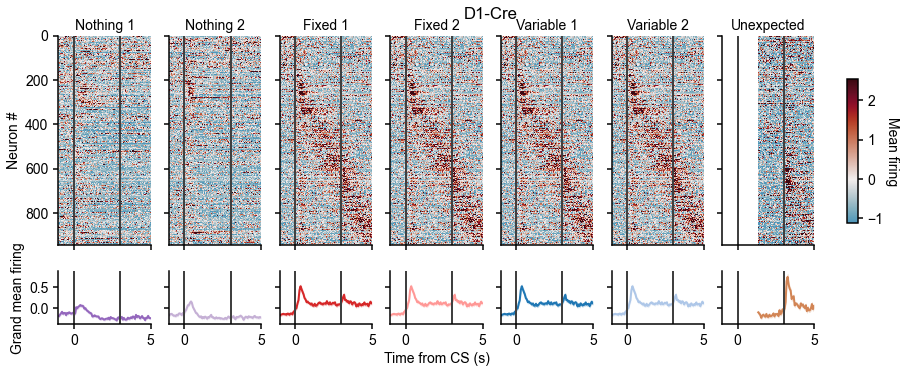

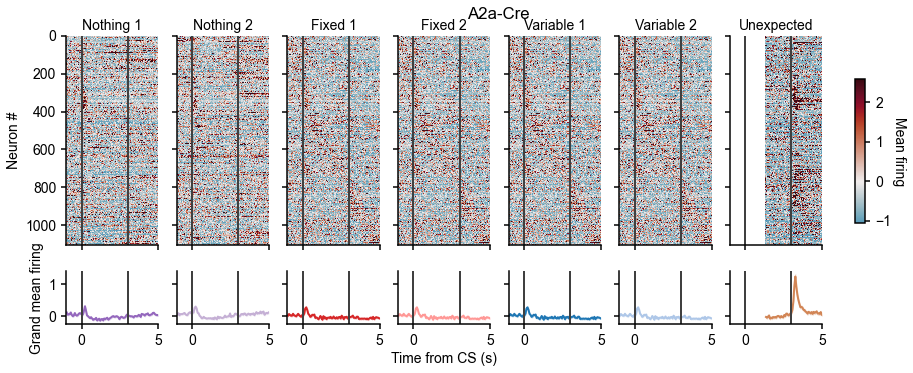

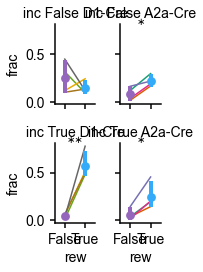

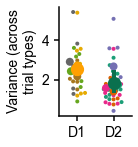

In [46]:
if plot_fig == 'fig4':
    
    ########## 10a-b. Slight differences result from using un-smoothed timecourse   #############
    cs_subtimecourse_norm = (cs_subtimecourse - np.array(np.nanmean(cs_subtimecourse, axis=(0, 2))).reshape(1, -1, 1)) / np.array(
    np.nanstd(cs_subtimecourse, axis=(0, 2))).reshape(1, -1, 1)
    sigma_s = 0.100  # 100 ms
    cs_subtimecourse_norm[exclude_tt, :, std_time < timestamps['stim'] + sigma_s*3] = np.nan

    for class_label in class_labels:
        val = neuron_info[class_name] == class_label
        suffix = '_' + class_label + '_neurons_sorted_cs' + str(n_trace_types)
        timecourse = cs_subtimecourse_norm[:, val, ::ds_factor]
        sort_sub_peak_inds = np.argsort(peak_inds[val])
        label_heatmap(n_trial_types, protocol_info['trial_type_names'], pcolor_time,
                      timecourse[pou][:, sort_sub_peak_inds, :], colors['colors'][pou],
                      total_cells, paths, suffix, 'firing')
        plt.suptitle(class_label)

    ########### 10d. Differences relative to baseline. ###########
    
    baseline_ind = 0
    rstats = np.zeros((2, total_cells))
    rps = np.zeros((2, total_cells))
    # baseline_reps > lt_resps --> statistic is negative
    # lt_resps > baseline_resps --> statistic is positive
    for i, type_range in enumerate([np.array([0, 1]), np.arange(2, n_trace_types)]):
        for i_cell in range(total_cells):
            baseline_resps = cue_resps[type_range, i_cell, :, baseline_ind]
            lt_resps = cue_resps[type_range, i_cell, :, late_trace_ind]
            rstats[i, i_cell], rps[i, i_cell] = stats.ranksums(
                lt_resps[~np.isnan(lt_resps)], baseline_resps[~np.isnan(baseline_resps)])
            
    neuron_info[['unrew_rstat', 'rew_rstat']] = rstats.T
    neuron_info[['unrew_sig_inc', 'rew_sig_inc']] = np.logical_and(rps < alpha, rstats > 0).T
    neuron_info[['unrew_sig_dec', 'rew_sig_dec']] = np.logical_and(rps < alpha, rstats < 0).T

    mouse_agg = neuron_info.groupby(['genotype', 'names'], as_index=False).mean().melt(
        id_vars=['genotype', 'names'], value_vars=['unrew_sig_inc', 'rew_sig_inc', 'unrew_sig_dec', 'rew_sig_dec'], var_name='sig', value_name='frac')
    mouse_agg['rew'] = ~mouse_agg['sig'].str.contains('unrew')
    mouse_agg['inc'] = mouse_agg['sig'].str.contains('inc')

    col_order = class_labels
    tests = {k: {False: 1, True: 1} for k in col_order}
    for col in col_order:
        for inc in tests[col].keys():
            
            unrew = mouse_agg.loc[np.logical_and.reduce([
                mouse_agg[class_name] == col, mouse_agg['inc'] == inc, mouse_agg['rew'] == False]), 'frac']
            rew =  mouse_agg.loc[np.logical_and.reduce([
                mouse_agg[class_name] == col, mouse_agg['inc'] == inc, mouse_agg['rew'] == True]), 'frac']
            
            _, tests[col][inc] = stats.ttest_rel(unrew, rew)
            
            print(col, inc)
            print(np.mean(rew.values - unrew.values))
            print(stats.sem(rew.values - unrew.values))

    g = sns.relplot(data=mouse_agg, row='inc', col=class_name, x='rew', y='frac', hue='names', col_order=class_labels,
                palette=mouse_colors, kind='line', height=2, aspect=.65, legend=False, zorder=1).set_titles('inc {row_name} {col_name}')
    g.map_dataframe(sns.pointplot, x='rew', y='frac', hue='rew', palette=['#9467bd', '#33abf9'], errwidth=4, 
                    errorbar=('ci', 95))
    for i_row, row in enumerate([False, True]):
        for i_col, col in enumerate(col_order):
            plot_stars(g.axes[i_row, i_col], [0.5], [tests[col][row]])
    plt.savefig('figs/inc_dec_rel_baseline.pdf')

    ############# 10e. Variance across trial types   ###########
    
    neuron_info['tt_var'] = np.var(X_means_norm[:n_trace_types, :, late_trace_ind], axis=0)
    sess_var = neuron_info.groupby(['names', 'file_dates', 'fig_paths', 'genotype'], as_index=False).mean()
    mouse_var = sess_var.groupby(['names', 'genotype'], as_index=False).mean()

    plt.figure(figsize=(1.3, 2))
    sns.swarmplot(sess_var, x='genotype', y='tt_var', hue='names', palette=mouse_colors, order=class_labels, 
                  size=4, legend=False, zorder=0)
    sns.swarmplot(mouse_var, x='genotype', y='tt_var', hue='names', palette=mouse_colors, order=class_labels, 
                  size=8, legend=False, zorder=1)
    sns.pointplot(mouse_var, x='genotype', y='tt_var', hue='genotype', palette=class_colors, order=class_labels, 
                  hue_order=class_labels, scale=1.5, errwidth=4)
    plt.legend().remove()
    plt.ylabel('Variance (across\ntrial types)')
    plt.xticks([0, 1], ['D1', 'D2'])
    plt.xlabel('')
    hide_spines()
    plt.savefig('figs/variance_across_trial_types_{}.pdf'.format('_'.join(class_labels)))